# Histopathologic Cancer Detection¶
## Identification of Metastatic Tissue in Histopathologic Scans of Lymph Node Sections
**Team 5**
- Wei Wu, Leeker, Katherine, Peng, Daniel, Stanowski, Andrew

# Part 1: Project Description

- In this competition, we are going to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. 

- The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.

- The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates.

- The purpose of this competition is to create an algorithm to identify metastatic cancer in small patches take from larger pathology scans. Cancer that spreads from where it started to a different part of the body is called metastatic cancer. It can also be considered stage 4 in some types of cancers.

Important characteristics for this project are stated below:

220,025 training images

57,456 test images

images are 96x96 pixels

images are in tif format

AUC (area under the curve) metric used

### For this project, we've used image data generator to scaled the images down to a smaller size 32 x 32 or 64 x 64
We've run into memory issues when using the original 96 x 96 images.It might because we've used too many epochs(total is 90). If we had time, we would try using 96 x 96 images and run for less epochs(like 30 or 40)

## Reason why we using cropped images dataset after building the baseline model

The training distribution seems to be 60/40 (negatives/positives).

A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. Tumor tissue in the outer region of the patch does not influence the label. 

This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.

# Part 2: Exploratory Data Analysis
- A sample of images in the training set.
- Label distribution.
- Histograms showing the distribution of pixel values in each of the three channels, for both the test set and training set (a total of 6 histograms).

### Part 2-1: Label distribution

Import Packages

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
from numpy.random import seed
seed(45)
import pickle

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
from glob import glob 
%matplotlib inline

In [ ]:
train_dirname = '/kaggle/input/histopathologic-cancer-detection/train'

In [ ]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels.head()

In [ ]:
train_labels['label'].value_counts() 
## we can see the training dataset contains 130908 negative samples, and 89117 positive samples
## It is not a purely balanced dataset 50:50,but it is seems ok with 60:40

In [ ]:
# Display a DataFrame showing the proportion of observations with each 
# possible of the target variable (which is label). 
(train_labels.label.value_counts() / len(train_labels)).to_frame()

### part 2-1: A sample of images in the training set¶

In [ ]:
positive_samples = train_labels.loc[train_labels['label'] == 1].sample(4)
negative_samples = train_labels.loc[train_labels['label'] == 0].sample(4)
positive_images = []
negative_images = []
for sample in positive_samples['id']:
    path = os.path.join(train_dirname, sample+'.tif')
    img = cv.imread(path)
    positive_images.append(img)
        
for sample in negative_samples['id']:
    path = os.path.join(train_dirname, sample+'.tif')
    img = cv.imread(path)
    negative_images.append(img)

fig,axis = plt.subplots(2,4,figsize=(20,8))
fig.suptitle('Dataset samples presentation plot',fontsize=20)
for i,img in enumerate(positive_images):
    axis[0,i].imshow(img)
    rect = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='g',facecolor='none', linestyle=':', capstyle='round')
    axis[0,i].add_patch(rect)
axis[0,0].set_ylabel('Positive samples', size='large')
for i,img in enumerate(negative_images):
    axis[1,i].imshow(img)
    rect = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    axis[1,i].add_patch(rect)
axis[1,0].set_ylabel('Negative samples', size='large')
    

### Part 2-3: Histograms showing the distribution of pixel values in each of the three channels, for both the test set and training set (a total of 6 histograms).


EDA for the distribution of all pixel values of each channel, notebook:
https://www.kaggle.com/amythecoolest/ww-cancer-detection-eda-v02


Built the 6 histograms for actual channel values (3 for each class), and 6 histograms for average channel values (3 for each class)

**For the average channel values, we can spot obvious differences between the positive and negative samples.**

The distribution of mean brightness for the positive samples looks almost like a normal distribution around a brightness of 150-200.

The negative samples, however, seem to follow some bimodal distribution with 2 peaks.

**For actual channel values, we can already spot differences in the distributions of all channels individually between positive and negative samples:**
-	Negative samples seem to have higher, i.e. brighter, pixel values in general and especially in the green color channel.
-	Interestingly, the positive samples have a darker green channel than red and blue while this is not true for the negative samples. However, very dark pixels are for both sample sets mostly only present in the green channel.


# Part 3:  The class activation maps
- This technique involves creating heatmaps that shows us what part of an image the network is most interested in when determining its classifications. For any image, we create one heatmap for each class. The heatmap will tell us what part of the image most strongly indicates the presence of the class in question. These don’t provide us with any filter-level information, but they are a great way to get a sense as to what our network is learning.

- We've chosen one of our best models and presented the heatmap for each single selected image. Typically, if there are any red spots, the model will consider it Has Cancer, vice versa.

Kaggle notebook:

https://www.kaggle.com/amythecoolest/ww-cancer-detection-visualizations


https://www.kaggle.com/danielpeng1995/daniel-cancer-detection-class-activation-maps


https://www.kaggle.com/katherineleeker/kl-class-activation-maps


# Part 4: Summary of some prominent models we've trained
notebooks from each team member

## Section 1: Baseline CNN Model

 Notebook : https://www.kaggle.com/amythecoolest/ww-cancer-detection-v01?scriptVersionId=79032156
 
- The images are 96*96 pixels, and we have about 220,000 training data and 57,000 test data
- For the baseline models, we used image data generator to scaled the images down to a smaller size 32*32, this will reduce the training time.

The structure of the baseline model contains:

2 Conv2D layers

4 Dense layers

80-20 training test split

Learning rate of 0.001 for 30 epochs, followed by 0.0001 for 30 epochs, followed by 0.00001 for 30 epochs.

The 2 Conv2D layers include 16, 32 filters with a 0.25, and 0.5 dropout

The 3 Dense layers include 64, 16, 8, and 2 units with a 0.5, 0.5 and 0.25 dropout.

We set learning rate = 0.001, epochs = 30 at the begining, it gives us about 80-90% percent accuracy. 
The validation curve had significant noise, so it was clear to run more epochs with a lower learning rate.

Then we set Learning rate of 0.0001 for 30 epochs followed by 0.00001 for 30 epochs.
The validation AUC became flat and smooth after 36 epochs, and the validation line and training line are close enough, so we stop training and save the model.

## Section 2: Models using cropped images dataset, and apply data augmentation

- The data page for the competition explains that for the training set, at least, the tumors are confined to the center 32x32 region of the image. 
- We pressume this is the case for the test images as well, then it would be a good apporach if we cropped the full images into the center 32*32.
- This will reduce our images to 1/9 the size of the originals, which will significantly speed up the training process.

- public Kaggle Dataset containing versions of the images that have been cropped down to the center 32x32 provided by Dr. Beane.
https://www.kaggle.com/drbeane/hcd-cropped




### Image augmentation only applied on the training data set, at the beginning, I still use a relatively small training Dataset (10000 positive images and 10000 negative images)
The training notebook we've used:
https://www.kaggle.com/amythecoolest/ww-hcancer-detection-cropped-v01?scriptVersionId=79439467

The submission notebook: 
https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-crop-v02?scriptVersionId=79531127

The submission score we've achieved:

public0.8677 private0.8189

- Image augment refers to the technique of artificially creating additional training observations by applying image transformations (such as scaling, rotations, and translations) to the original training images.


- Image transformations should ONLY be applied to training set. They should not be applied to the validation set or test set. The point of image augmentation is to inhibit the model's ability to overfit during training, but the model does not train on the validation or test sets, so there is no reason to apply image augmentation to these sets.

### Because We were using a relatively small dataset for training my CNN model, the result was not as expected when we applied the image augmentation to the training images. 

### We've decided to enlarge the training dataset, 89117 positive images and the same amount of negative images to see whether it helps.

- The training notebook is: https://www.kaggle.com/amythecoolest/ww-hcancer-detection-cropped-v01?scriptVersionId=79842597

- The submission notebook is:
https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-crop-v02?scriptVersionId=79869654

- The accuracy score is

public 0.8844, private 0.8304

Enlarge the size of the training set did help to improve the accuracy, but not a big change.

## Section 3: The Models using full images and without data augmentation tend to perform better, so we go back to focus on the training on the full images dataset

### Tricks we've learned to speed up the training process especially for image classification by adding 2 lines inside cnn.fit() function:

    use_multiprocessing = True
    workers = 8


## Another pretty basic model with a high score

## Modified my CNN's structure(VGG with 3 blocks), increase the dropout rate, using Batch Normalization to get a decent model

The training notebook:
https://www.kaggle.com/amythecoolest/cancer-detection-v03?scriptVersionId=80411362

The submission notebook:
https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-v02?scriptVersionId=80413786

The submission score:

public 0.9063, private 0.8556


The structure above contains:

3 Conv2D layers

4 Dense layers

80-20 training split

Learning rate of 0.001 for 30 epochs, followed by 0.0001 for 30 epochs, followed by 0.00001 for 30 epochs.


The 3 Conv2D layers include 32, 64, and 128 filters with a 0.4, 0.5, and 0.6 dropout

The 3 Dense layers include 128, 16, 8, and 2 units with a 0.5, 0.4 and 0.3 dropout.

## Section 4:  Models using transfer learning VGG16 pre-trained model and fine tuning

### Part 4-1: Models using VGG16 pre-trained model without fine-tuning

### Training preparation -
we used image data generator to scaled the images down to 64*64, and sampled 10000 positive training images and 10000 negative training images.

The training notebook
https://www.kaggle.com/amythecoolest/ww-cancer-detection-v04?scriptVersionId=80600115

The submission notebook
https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-v02?scriptVersionId=80716290

The submission score:
public 0.8825, private 0.8652

After setting up the structure of our CNN, we set Learning rate of 0.001 for 30 epochs followed by 0.0001 for 30 epochs followed by 0.00001 for 30 epochs.

### The accuracy of AUC is around 0.88, and the score didn't improve after we increased the dropout rate.

### Part 4-2: Using VGG16 train another model without fine-tuning
we used image data generator to scaled the images down to 64*64, (larger training dataset)40000 positive training images and 40000 negative training images

Based on the result, the performance improved a little bit.

Training notebook

https://www.kaggle.com/amythecoolest/ww-cancer-detection-v04/notebook?scriptVersionId=80777805

submission notebook

https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-v02?scriptVersionId=80810446

submission score

public 0.8924 private 0.8691

### Part 4-3: Models using VGG16 pre-trained model with fine-tuning

### First Model

training notebook

https://www.kaggle.com/amythecoolest/cancer-detection-v05?scriptVersionId=81150420

submission notebook

https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-v03?scriptVersionId=81203579

submission score

public0.9211 private 0.9126

### At the beginning, we set epochs = 5, in order to reduce the training time.
We need to set base_model.trainable = False at first.

For the baseline model, we set Learning rate of 0.001 for 5 epochs followed by 0.0001 for 5 epochs.

### Then we moved on to the fine-tuning process
Fine-tuning is a technique that allows us to adjust the layers in a pretrained convolutional base to let it adapt to the new dataset it is being applied to. 

This is accomplished by unfreezing the layers in the base, setting a low learning rate, and then training for some number of additional epochs.

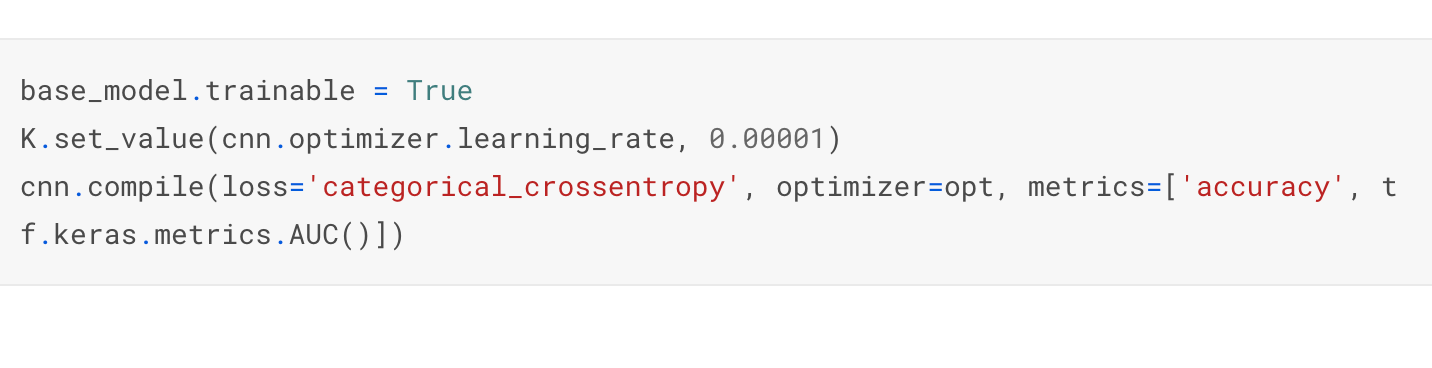

We set learning rate to 0.0001, and run another 5 epochs.

Below is the plot for AUC score:


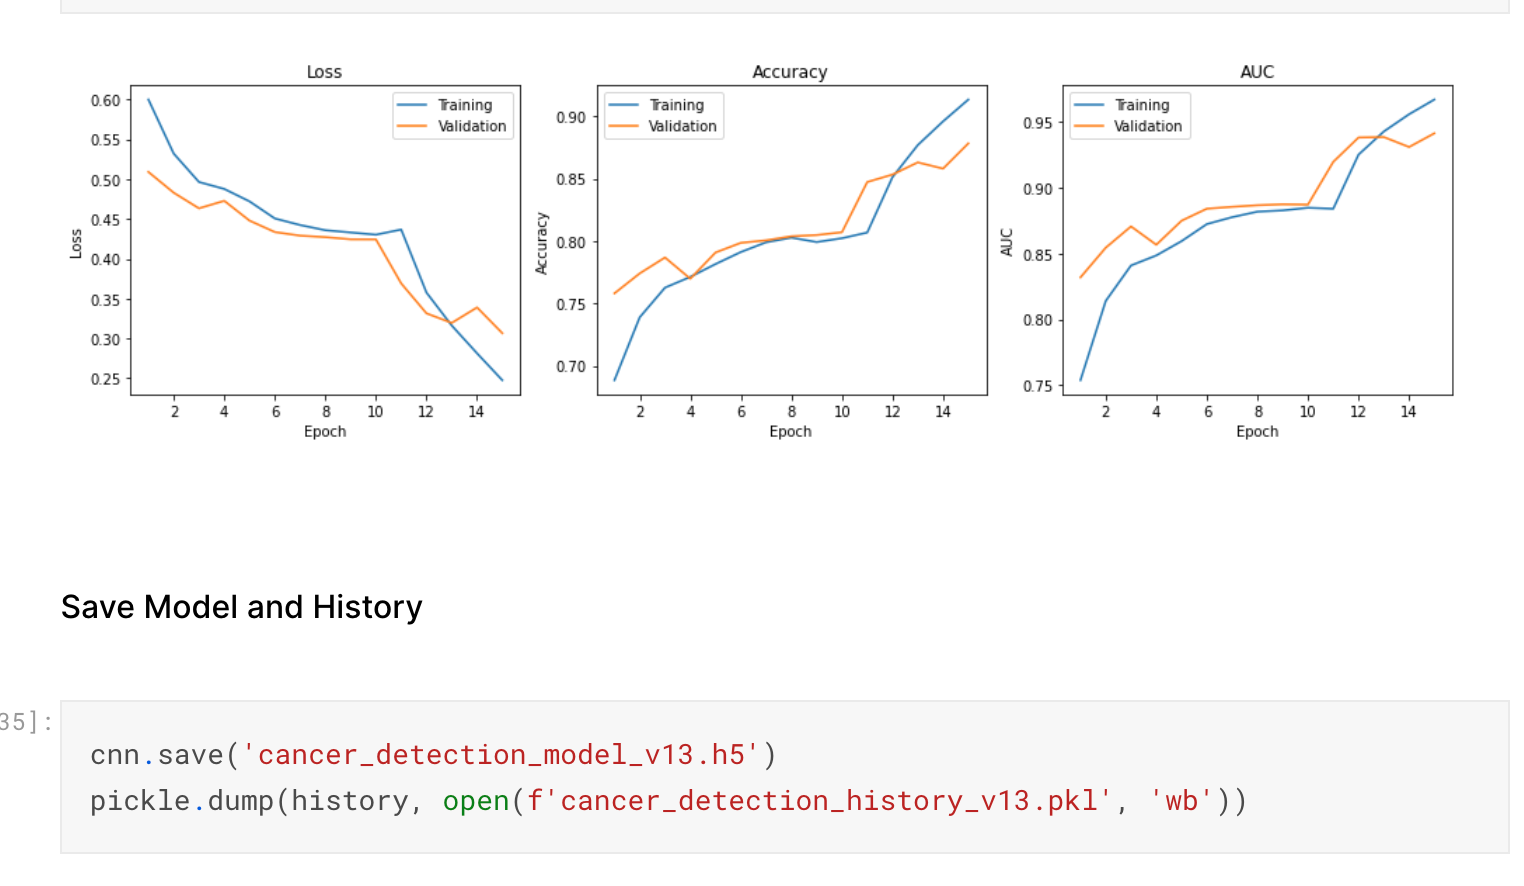

Even for 15 epochs, the validation AUC is very good compares to our previous model

### Second Model

training notebook

https://www.kaggle.com/amythecoolest/cancer-detection-v05?scriptVersionId=81210177

submission notebook

https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-v03?scriptVersionId=81203579


submission score
public 0.9242, private 0.9042

In this model, we set Learning rate of 0.001 for 15 epochs followed by 0.0001 for 15 epochs, for the fine tunning part, we set learning rate of 0.0001 for 10 epochs.
the result did increase, but just a small amount.

## Section 5: Model using voting ensemble

submission notebook:
https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-v04-ensem/notebook?scriptVersionId=81474978


submission score:
public 0.9247 private 0.9025



### We've chosen the best three models and used the mean of the three outputs to make the prediction.

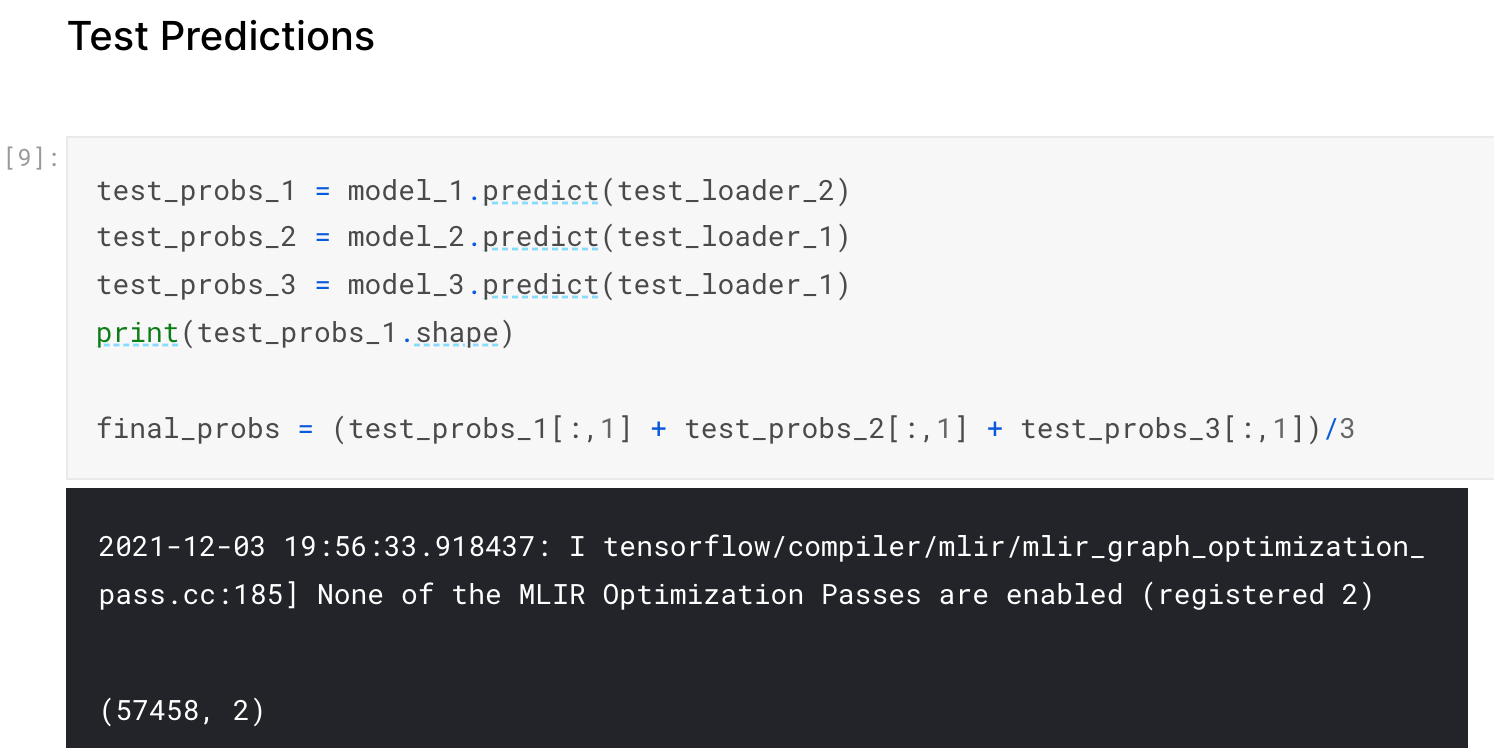

## Section 6: Model using stacking ensemble

submission notebook:

https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-v05-ensem?scriptVersionId=82075373


submission score:

public 0.9304, private 0.9095

### Things we need to aware for stacking ensemble

1. We should NOT shuffle either the training set or the validation set in this case. That is only used when you are training the neural net models.

2. We should also not apply any data augmentation to the training or validation images.




### Step 1: choose the best 3 models

Two baseline models, and one model using transfer learning and fine-tuining.

The public score for the three models are: 0.8979, 0.9063 and 0.9242.

### Step 2: The way to generate the new training dataset for meta learner.

**First, we got 3 model prediction columns:**

    train_pred_1 = model_1.predict(train_loader_2)[:,1]

    train_pred_2 = model_2.predict(train_loader_1)[:,1]

    train_pred_3 = model_3.predict(train_loader_1)[:,1]

**Then, we construct a new dataframe with the 3 new columns generated above:**

    X_train = pd.DataFrame({
 
        'model_1': train_pred_1,
    
        'model_2': train_pred_2,
    
        'model_3': train_pred_3
     })

**We use same way to construct validation and test dataframe**

**The labels for training and validation set shown as below:** We did NOT shuffle either the training set or the validation set in this case to make sure each sample is constent with its label

    y_train = train_df['label']

    y_valid = valid_df['label']

### Step 3: Train a logistic regression model and using grid search to choose the best model.

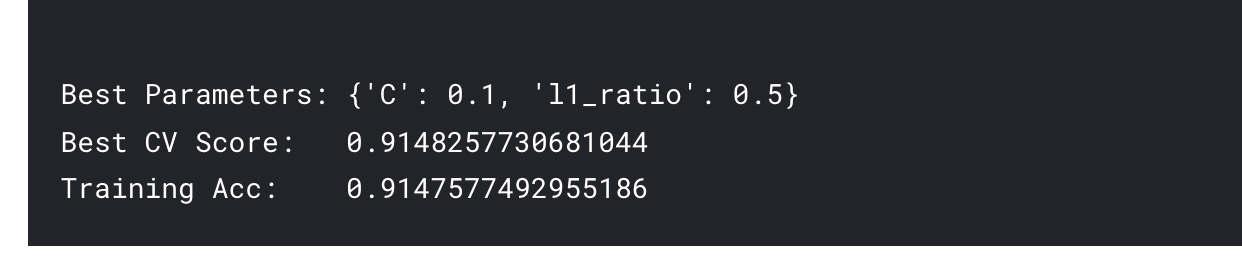

### Step 4: we used the best model to generate predictions for the test set, and got our best submission result:

### public 0.9304, private 0.9095

# Part 5: technical challenges

### The biggest challenge was trying to understand what was actually happening to the code and the model. 

For example, the size of the images. We have size 32 by 32 and then we have size 96 by 96 for the images. We have to resize the images so that it fits with the model.

We've trained our baseline model, and then we've tried different techniques to add them to our baseline model to improve our model accuracy. The technics we've used include Image Augmentation, Transfer Learning with and without fine-tuning, ensemble our best several models using voting or stacking. 

Whenever we implement new technics, it is not always successful initially, but we managed to improve our model performance steadily. And we've found out that ensembling our best models tends to have a better result.


# Part 6:  Summary of the final results
including confusion matrix and classification report

- Accuracy. Note if the score obtained is similar to the validation score obtained by this model. This will give us a sense as to if the rest of the analysis is trustworthy. 
- Classification Report. There are tools in sklearn for constructing this.
- Confusion Matrix. There are tools in sklearn for constructing this.
- Distribution of Probability Predictions. It would be interesting to see histograms displaying the distributions of probability estimates generated for the positive classes. Since you have the labels for the validation set, you can create two histograms for this: One for positive labels and one for negative labels. In fact, going a step further, you can create four histograms, one each for TP, FP, TN, and FN.

## Our best model is using stacking ensemble technics, and the best score is:

submission notebook:

https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission-v05-ensem?scriptVersionId=82075373

public 0.9304, private 0.9095

### At the beginning, we've chosen one decent model (with submission score: 0.9184 public) to do the evaluation.

submission notebook: 

https://www.kaggle.com/amythecoolest/ww-cancer-detection-submission?scriptVersionId=82157691

### We've used image data generator to load not only the test images, but also trainig images, and used train_test_split to create validation set for confusion matrix and Classification report.


Generate the confusion matrix

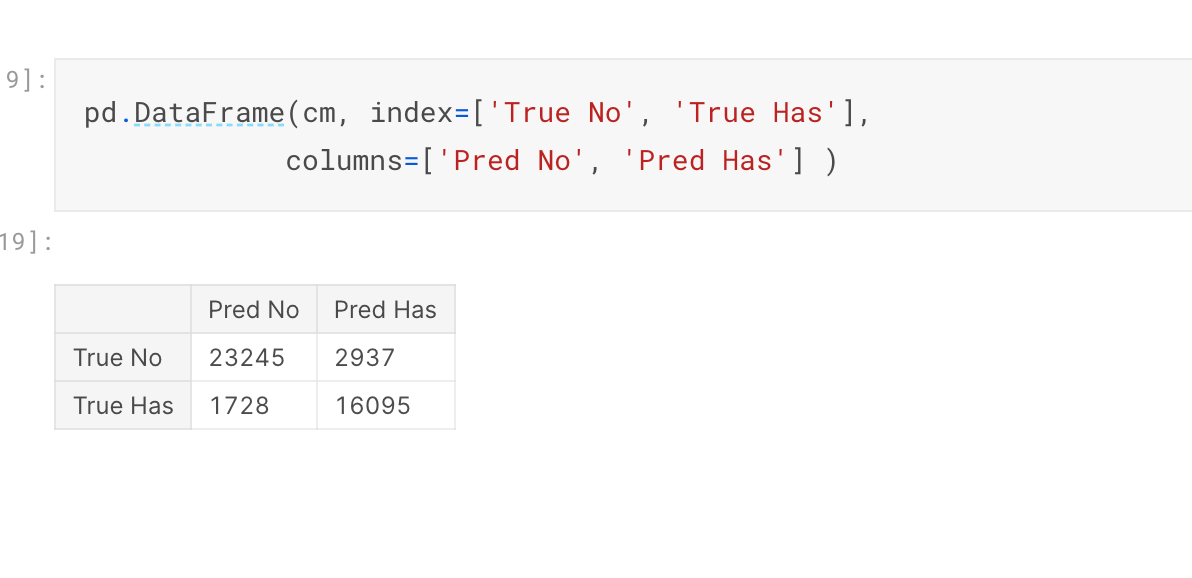

- We can see 23245 sample is correctly predicted as No cancer, and 16095 samples is correctly predicted as Has Cancers.


- There are 2937 samples predicted as has cancer, but actually dont't have cancer.


- Ther are 1728 samples predicted as has no-cancer, but actually have cancer.

Generate Classification Report

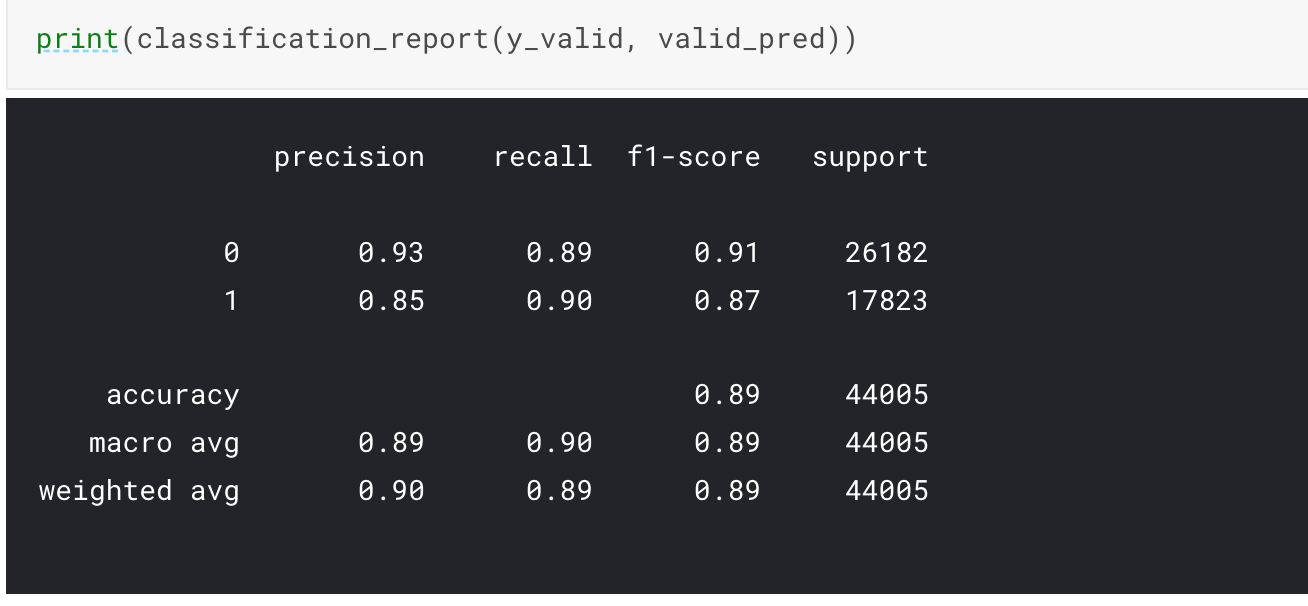

### Then we moved on to the evaluation of our Best Model

### Generate the confusion matrix and classification, we can see that our accuarcy (f1-score) increased from 0.89 to 0.91.

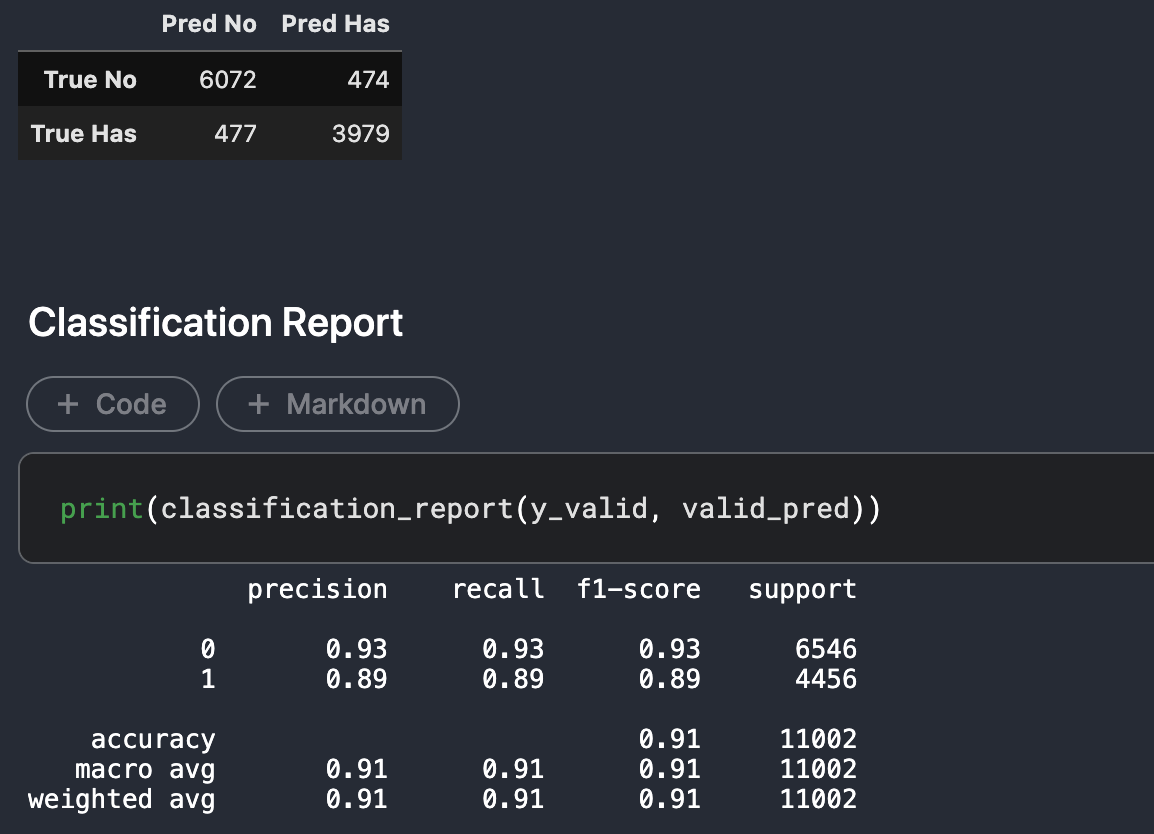

# Part 7:  Links to other notebooks

1. A model with 0.9128 public score

https://www.kaggle.com/danielpeng1995/daniel-report-notebook


    
2. A model with 0.9239 public score

Submission: https://www.kaggle.com/drewstanowski/as-cancer-detection-submission

Training: https://www.kaggle.com/drewstanowski/training-cancer



3. A model with 0.9109 public score


https://www.kaggle.com/katherineleeker/kl-cancer-submission 

https://www.kaggle.com/katherineleeker/kl-cancer-training

The best scores for this training notebook are with versions 3, 7, and 14.


